In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
sample_set = 'k33'
target = 'k'

plt.style.use('seaborn-whitegrid')

to_do = [('alex',       f'alexnet_{sample_set}/alex_{sample_set}'),
         ('mobilenet',  f'mobilenet_{sample_set}/mobilenet_{sample_set}'),
         ('resnext',    f'resnext_{sample_set}/resnext_{sample_set}')
         ]

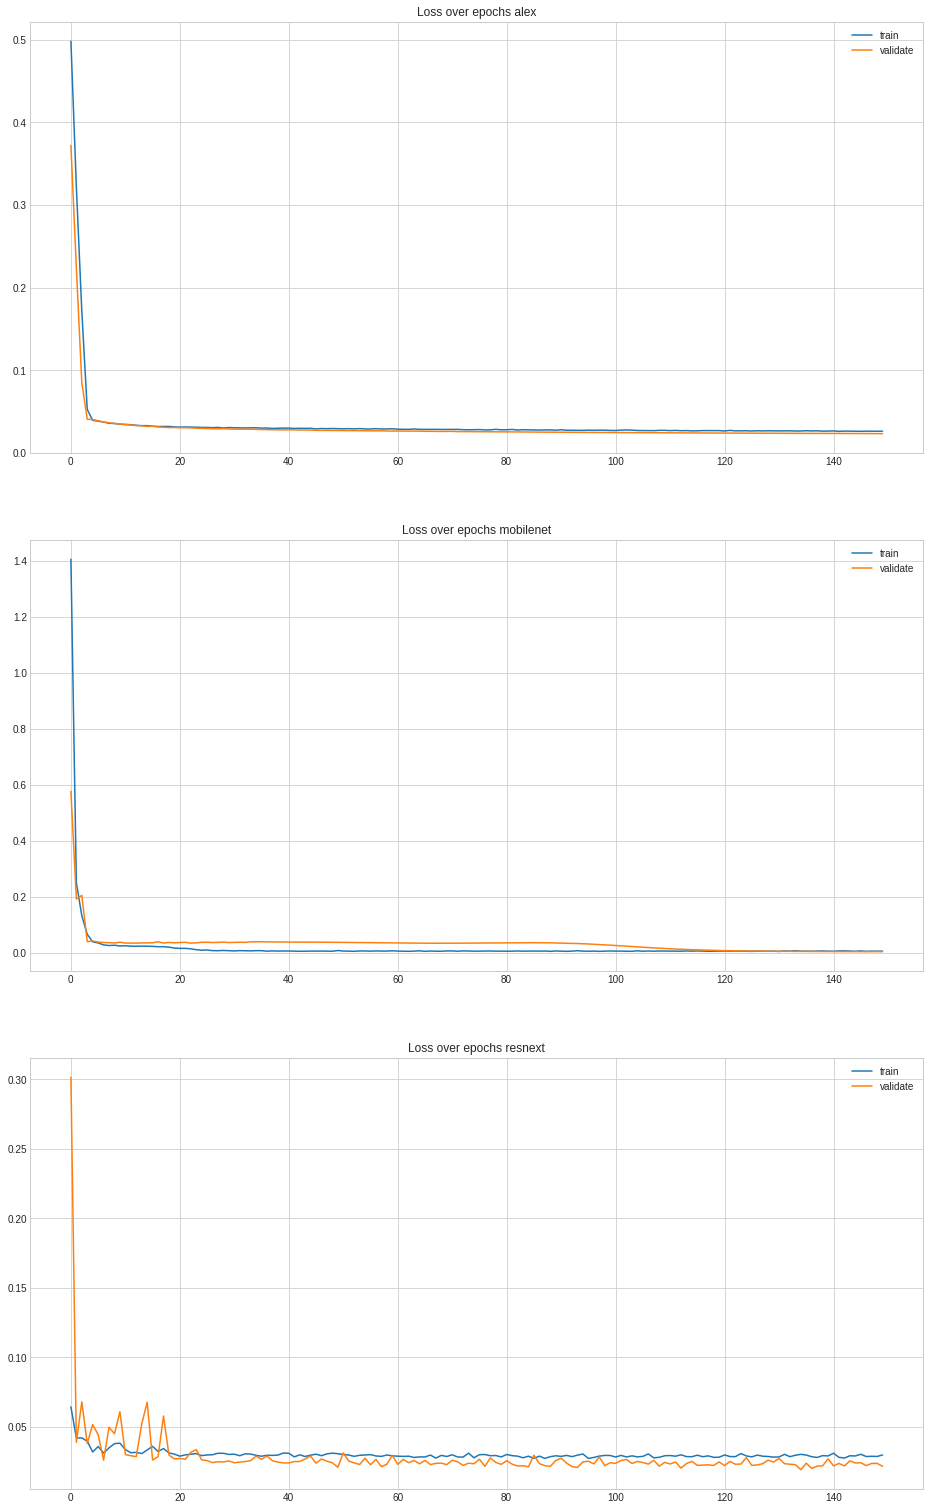

In [2]:
# Plot training result
fig,ax = plt.subplots(nrows=3, figsize=(16,9*3))
for index, (name, path) in enumerate(to_do):
    train_loss = pickle.load(open(f'{path}_train_loss.txt', 'rb'))
    val_loss = pickle.load(open(f'{path}_val_loss.txt', 'rb'))
    ax[index].set_title(f'Loss over epochs {name}')
    ax[index].plot(train_loss, label='train')
    ax[index].plot(val_loss, label='validate')
    ax[index].legend()
plt.show()

del(val_loss)
del(train_loss)

In [3]:
# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set=sample_set,target=target)
full_dataset.transform = preprocess
print(len(full_dataset))

BATCH_SIZE=64
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

872


In [4]:
def load_model(name, pretrain=None):
    model = None
    if(name == 'alex'):
        model = models.alexnet()
        model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1,bias=True)
    elif(name == 'mobilenet'):
        model = models.mobilenet_v3_large()
        model.classifier[3] = torch.nn.Linear(in_features=1280,out_features=1,bias=True)
    elif(name == 'resnext'):
        model = models.resnext50_32x4d()
        model.fc = torch.nn.Linear(in_features=2048,out_features=1,bias=True)
    else:
        raise ValueError(f"name:{name} is not defined")

    if(pretrain!=None):
        model.load_state_dict(torch.load(pretrain, map_location='cpu'))
    return model

import math
def get_class(score, target):
    if(target == 'n'):
        n_range = [0,2,2.4,3,math.inf]
        if(score < 2):
            return 1
        if(score < 2.4):
            return 2
        if(score < 3):
            return 3
        else: return 4
    elif(target == 'k'):
        k_range = [0,0.75,0.90,1.2,math.inf]
        if(score < .75):
            return 1
        if(score < .9):
            return 2
        if(score < 1.2):
            return 3
        else: return 4
    else:
        raise ValueError(f"target:{target} is incorrect")


def predict(model, dataloader, device='cpu'):
    all_preds = None
    all_labels = None
    model.to(device)
    with torch.no_grad():
        for index, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1,1)
            # print(inputs,labels)
            preds = model(inputs)
            if(all_preds == None):
                all_preds = preds.cpu().view(-1)
                all_labels = labels.cpu().view(-1)
            else:
                all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
                all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)

    return all_preds, all_labels

def print_performance(all_preds, all_labels, target):
    acc = 0
    acc_class = dict()
    len_class = dict()
    err = 0
    err_class = dict()
    # class_3 = []
    for idx in range(len(all_preds)):
        # get class
        pred,label = all_preds[idx], all_labels[idx]
        class_pred = get_class(pred, target)
        class_act = get_class(label, target)
        
        # init if unseen class
        if(class_act not in len_class.keys()):
            acc_class[class_act] = 0
            err_class[class_act] = 0
            len_class[class_act] = 1

        # Check result
        if(class_act == class_pred):
            acc += 1
            acc_class[class_act] += 1
        len_class[class_act] += 1
        err += abs(pred - label)
        err_class[class_act] += abs(pred - label)
        # if(class_act == 3 and class_pred != 3):
        #     class_3.append((full_dataset.filenames[idx],pred,label))

    print('Over All acc: ',acc/len(all_preds) * 100)
    print('Over All err: ',err/len(all_preds))

    for k,v in acc_class.items():
        print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
        print(f"Err of Class {k}: {err_class[k]/len_class[k]}")


alex alexnet_k33/alex_k33
Over All acc:  55.96330275229357
Over All err:  tensor(0.1243)
Acc of Class 2: 115/242 = 47.5206611570248
Err of Class 2: 0.07464339584112167
Acc of Class 1: 369/494 = 74.69635627530364
Err of Class 1: 0.1106523871421814
Acc of Class 3: 4/131 = 3.0534351145038165
Err of Class 3: 0.2393522709608078
Acc of Class 4: 0/9 = 0.0
Err of Class 4: 0.4768480658531189

mobilenet mobilenet_k33/mobilenet_k33
Over All acc:  71.78899082568807
Over All err:  tensor(0.0723)
Acc of Class 3: 97/131 = 74.04580152671755
Err of Class 3: 0.0784878134727478
Acc of Class 2: 154/242 = 63.63636363636363
Err of Class 2: 0.06054338067770004
Acc of Class 1: 375/494 = 75.91093117408907
Err of Class 1: 0.07438242435455322
Acc of Class 4: 0/9 = 0.0
Err of Class 4: 0.1542174369096756

resnext resnext_k33/resnext_k33
Over All acc:  55.1605504587156
Over All err:  tensor(0.1264)
Acc of Class 1: 360/494 = 72.8744939271255
Err of Class 1: 0.10659364610910416
Acc of Class 2: 109/242 = 45.0413223140

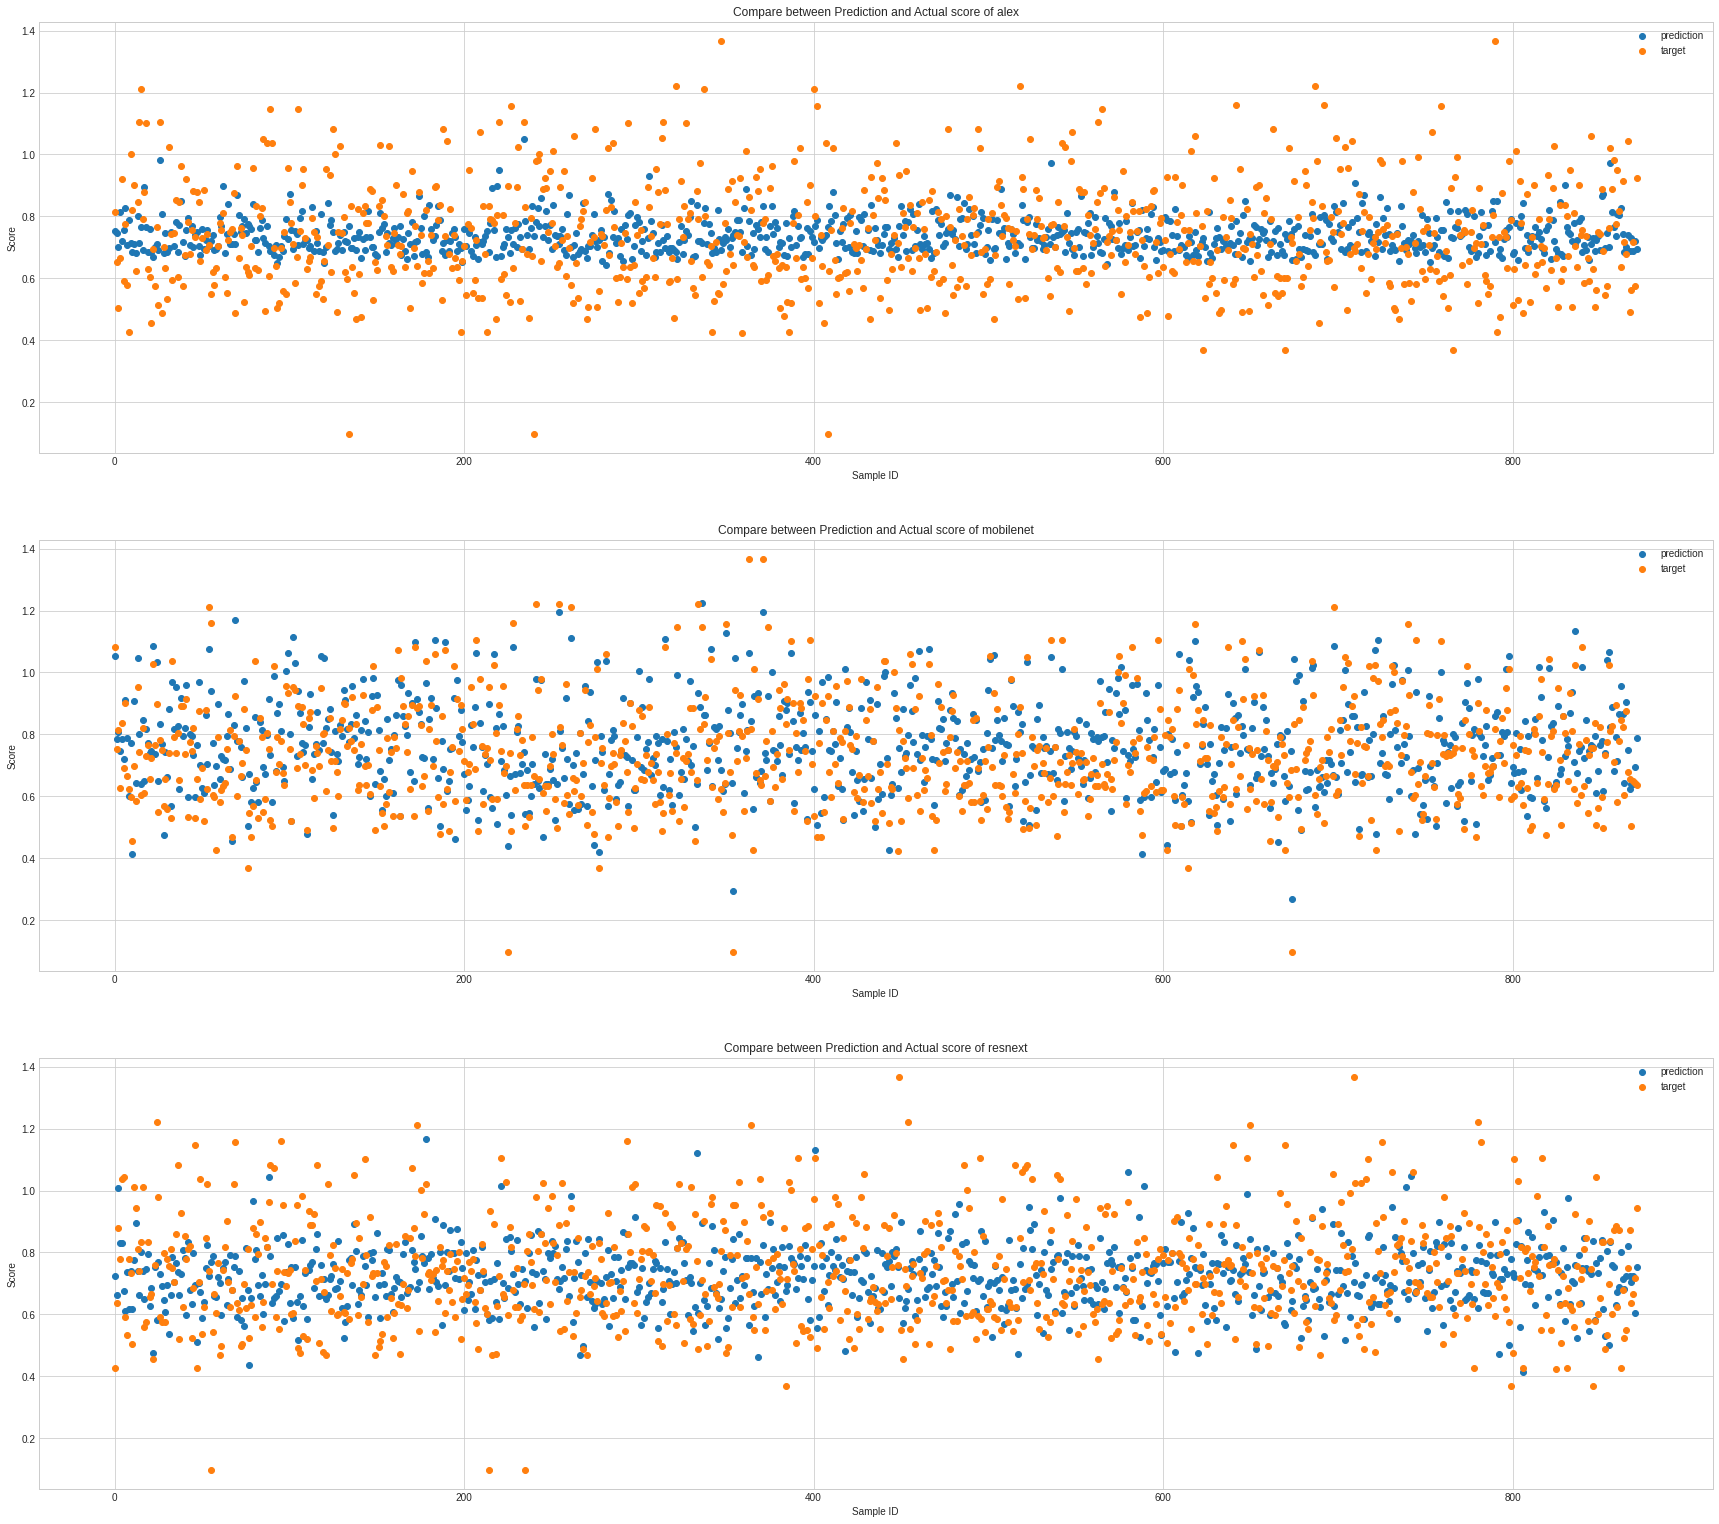

In [5]:
preds_of = dict()
labels_of = dict()
fig,ax = plt.subplots(3, figsize=(30,9*3))
for index, (name, weight) in enumerate(to_do):
    print(name, weight)
    print('='*20)
    model = load_model(name, f'{weight}.pth')
    all_preds, all_labels = predict(model, dataloader, 'cuda:0')
    preds_of[name] = all_preds
    labels_of[name] = all_labels
    ax[index].scatter(np.arange(len(all_preds)),all_preds,label='prediction')
    ax[index].scatter(np.arange(len(all_labels)),all_labels,label='target')
    ax[index].set_title(f'Compare between Prediction and Actual score of {name}')
    ax[index].set_ylabel('Score')
    ax[index].set_xlabel('Sample ID')
    ax[index].legend()
    print_performance(all_preds, all_labels, target)
    print()

plt.show()
del(model)

Top 5 Error example from [alex]
Filename:K336_33_3.JPG
Score Label:0.09799999743700027|Pred:0.7370517253875732|diff=0.6390517354011536
Class Label:1|Pred:1


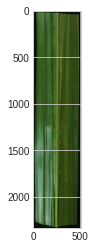

Filename:K251_33_3.JPG
Score Label:1.3660000562667847|Pred:0.7158032655715942|diff=0.6501967906951904
Class Label:4|Pred:1


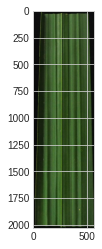

Filename:K397_33_4.JPG
Score Label:0.09799999743700027|Pred:0.7654751539230347|diff=0.667475163936615
Class Label:1|Pred:2


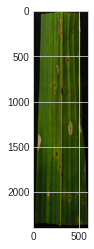

Filename:K217_33_5.JPG
Score Label:0.09799999743700027|Pred:0.7698104381561279|diff=0.6718104481697083
Class Label:1|Pred:2


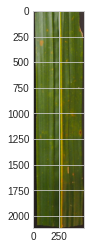

Filename:K412_33_3.JPG
Score Label:1.3660000562667847|Pred:0.6903203725814819|diff=0.6756796836853027
Class Label:4|Pred:1


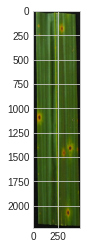

Top 5 Error example from [mobilenet]
Filename:K310_33_4.JPG
Score Label:0.9449999928474426|Pred:0.650139570236206|diff=0.2948604226112366
Class Label:3|Pred:1


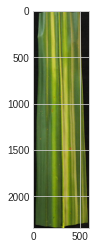

Filename:K257_33_1.JPG
Score Label:0.4880000054836273|Pred:0.7865052223205566|diff=0.2985052168369293
Class Label:1|Pred:2


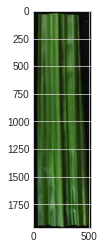

Filename:K318_33_3.JPG
Score Label:1.3660000562667847|Pred:1.0639450550079346|diff=0.3020550012588501
Class Label:4|Pred:3


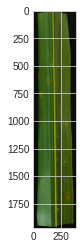

Filename:K42_33_4.JPG
Score Label:0.6179999709129333|Pred:0.9348700642585754|diff=0.3168700933456421
Class Label:1|Pred:3


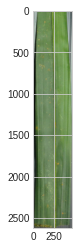

Filename:K440_33_4.JPG
Score Label:0.09799999743700027|Pred:0.43901583552360535|diff=0.34101584553718567
Class Label:1|Pred:1


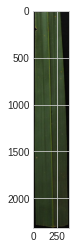

Top 5 Error example from [resnext]
Filename:K379_33_2.JPG
Score Label:0.09799999743700027|Pred:0.7067500948905945|diff=0.6087501049041748
Class Label:1|Pred:1


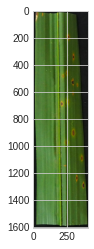

Filename:K392_33_3.JPG
Score Label:1.3660000562667847|Pred:0.6512542963027954|diff=0.7147457599639893
Class Label:4|Pred:1


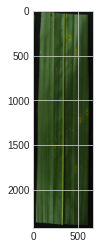

Filename:K416_33_2.JPG
Score Label:1.3660000562667847|Pred:0.7032920718193054|diff=0.6627079844474792
Class Label:4|Pred:1


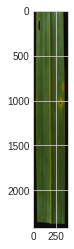

Filename:K214_33_4.JPG
Score Label:0.09799999743700027|Pred:0.7678201794624329|diff=0.6698201894760132
Class Label:1|Pred:2


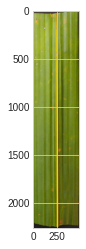

Filename:K343_33_5.JPG
Score Label:1.2209999561309814|Pred:0.58119136095047|diff=0.6398085951805115
Class Label:4|Pred:1


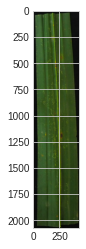

In [6]:
import matplotlib.image as mpimg

for name,_ in to_do:
    print(f"Top 5 Error example from [{name}]")
    print("="*20)
    preds = preds_of[name]
    labels = labels_of[name]
    errors = abs(preds - labels).numpy()
    # get top 5 error  
    idxs = np.argpartition(errors, -5)[-5:]
    for idx in idxs:
        filename = full_dataset.filenames[idx]
        pred = preds[idx]
        label = labels[idx]
        print(f"Filename:{filename}")
        print(f"Score Label:{label}|Pred:{pred}|diff={abs(label-pred)}")
        print(f"Class Label:{get_class(label,target)}|Pred:{get_class(pred,target)}")
        img = mpimg.imread(f'dataset/{sample_set}/{filename}')
        plt.imshow(img)
        plt.show()